# Data exploration
Explore the temporal structure of production data of renewable by center, technology (solar, wind, hydro, etc.), identify basic patterns, evaluate the quality of weather data, and detect possible relationship between climate variables, technology type of technology, demand and production


## Imports


### Third party packages


In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


### First party modules


In [2]:
# Get the project root
ROOT_DIR = Path.cwd().parent
sys.path.append(str(ROOT_DIR))

In [3]:
from src.data import filter_by_date_range, make_date_columns  # type: ignore


### Optional packages

In [4]:
try:
    from catppuccin import PALETTE  # Just for aesthetic proposes
    catppuccin_imported = True
except ImportError:
    print("The catppuccin package is not installed, no matter :), plots will use the default visual configuration.")
    catppuccin_imported = False

In [5]:
if catppuccin_imported:
    # Choose a flavor (latte, frappe, macchiato, mocha)
    flavor = PALETTE.mocha

    # Extract colors as hex values in a dict for easy access
    colors = {color.name.lower().replace(' ', '_'): color.hex for color in flavor.colors}

    # Define color cycle for plots (select the colors you want to use)
    color_cycle = [
        colors['blue'], colors['red'], colors['green'], 
        colors['yellow'], colors['pink'], colors['teal'],
        colors['peach'], colors['mauve'], colors['lavender']
    ]

    # Configure matplotlib
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_cycle)
    plt.rcParams['axes.facecolor'] = colors['base']
    plt.rcParams['figure.facecolor'] = colors['mantle']
    plt.rcParams['text.color'] = colors['text']
    plt.rcParams['axes.labelcolor'] = colors['text']
    plt.rcParams['xtick.color'] = colors['subtext_1'] 
    plt.rcParams['ytick.color'] = colors['subtext_1']
    plt.rcParams['axes.edgecolor'] = colors['surface_2']
    plt.rcParams['grid.color'] = colors['surface_0']

    # Configure seaborn
    sns.set_palette(color_cycle)
    sns.set_style({
        'axes.facecolor': colors['base'],
        'figure.facecolor': colors['mantle'],
        'text.color': colors['text'],
        'axes.labelcolor': colors['text'],
        'xtick.color': colors['subtext_1'],
        'ytick.color': colors['subtext_1'],
        'axes.edgecolor': colors['surface_2'],
        'grid.color': colors['surface_0']
    })

## Data


### Load data

In [6]:
# Change for "../data/raw/daily_energy_production.csv" for a classic path
data_path = ROOT_DIR / "data" / "raw"
historic_data_path = ROOT_DIR / "data" / "processed" / "csv_files"

demand_path = data_path / "hourly_demand.csv"
generation_path = data_path / "hourly_generation.csv"
historic_data_path_csv = historic_data_path / "2025-1.csv"

historic = pd.read_csv(historic_data_path_csv)
demand = pd.read_csv(demand_path)
generation = pd.read_csv(generation_path)

### Format data

In [7]:
# Rename columns with more readable names
demand = demand.rename(
    columns={
        "fecha": "date",
        "hora": "hour",
        "demanda": "demand",
    },
)
generation = generation.rename(
    columns={
        "Fecha y Hora": "datetime",
        "Tipo Tecnología": "tech_type",
        "Generación Real (MWh)": "generation_mwh",
    },
)

In [8]:
# Convert date columns to datetime
generation["datetime"] = pd.to_datetime(generation["datetime"])
demand["date"] = pd.to_datetime(demand["date"])
historic["fecha_opreal"] = pd.to_datetime(historic["fecha_opreal"])

# Add date columns
generation_processed = make_date_columns(generation, "datetime", use_24_hour=True)
demand_processed = make_date_columns(demand, "date", components=["year", "month", "day"])

# Add date to align with the demand `date` and drop the unnecessary `datetime`
generation_processed["date"] = pd.to_datetime(generation_processed["datetime"].dt.date)
generation_processed = generation_processed.drop(columns="datetime")

In [9]:
demand_processed["hour"].value_counts().sort_index()

hour
1     3646
2     3654
3     3654
4     3654
5     3654
6     3654
7     3654
8     3654
9     3654
10    3654
11    3654
12    3654
13    3654
14    3654
15    3654
16    3654
17    3654
18    3654
19    3654
20    3654
21    3654
22    3654
23    3654
24    3654
25       9
Name: count, dtype: int64

There is 9 values for 25, that is inconsistent with the 24 hours at the day. Also, the hour 1 have 8 values less than the others, this could be because of hour changes in Chile. So a possible approach could be convert these nine 25 values to 1 instead.

In [10]:
# Convert hour outliers (25 hour to 1)
demand_processed["hour"] = demand_processed["hour"].replace(25, 1)
# Convert demand values to float
demand_processed["demand"] = pd.to_numeric(demand_processed["demand"].str.replace(",", "."))

### Data Wrangling

In [11]:
demand_processed = demand_processed.rename(columns={"date": "fecha_opreal", "hour": "hora_opreal"})

In [12]:
start_date = "2025-01-01"
end_date = "2025-04-23"

demand_ranged = filter_by_date_range(demand_processed, "fecha_opreal", start_date, end_date)
generation_ranged = filter_by_date_range(historic, "fecha_opreal", start_date, end_date)

In [13]:
historic.head()

,fecha_opreal,hora_opreal,nemotecnico,nombre,central_nombre,central_infotecnica_id,coordinado,central_tipo,central_tipo_nemotecnico,subtipo,subtipo_nemotecnico,grupo_reporte_nombre,generacion_real_mwh,generacion_real_ernc_mwh
0,2025-01-01,1,ecantera,PMGD PFV Cantera,PMGD PFV CANTERA,1992,GPG GENERACIÓN DISTRIBUIDA SPA,Solar,solar,Solar,solar,PMGD PFV Cantera,0.0,0.0
1,2025-01-01,2,ecantera,PMGD PFV Cantera,PMGD PFV CANTERA,1992,GPG GENERACIÓN DISTRIBUIDA SPA,Solar,solar,Solar,solar,PMGD PFV Cantera,0.0,0.0
2,2025-01-01,3,ecantera,PMGD PFV Cantera,PMGD PFV CANTERA,1992,GPG GENERACIÓN DISTRIBUIDA SPA,Solar,solar,Solar,solar,PMGD PFV Cantera,0.0,0.0
3,2025-01-01,4,ecantera,PMGD PFV Cantera,PMGD PFV CANTERA,1992,GPG GENERACIÓN DISTRIBUIDA SPA,Solar,solar,Solar,solar,PMGD PFV Cantera,0.0,0.0
4,2025-01-01,5,ecantera,PMGD PFV Cantera,PMGD PFV CANTERA,1992,GPG GENERACIÓN DISTRIBUIDA SPA,Solar,solar,Solar,solar,PMGD PFV Cantera,0.0,0.0


In [14]:
granularity = ["fecha_opreal", "hora_opreal"]
demand_grouped = demand_ranged.groupby(by=granularity)[["demand"]].sum().reset_index()
generation_grouped = generation_ranged.groupby(by=[*granularity, "central_tipo_nemotecnico", "subtipo_nemotecnico"])[["generacion_real_mwh"]].sum().reset_index()

In [15]:
merged = generation_grouped.merge(demand_grouped, how="inner", on=["fecha_opreal", "hora_opreal"])

## Visualization

In [30]:
pivot = historic.pivot_table(
    index=["fecha_opreal", "hora_opreal"],
    columns="central_tipo_nemotecnico",
    values="generacion_real_mwh",
    aggfunc="sum",
)

In [37]:
energy_sources = historic["central_tipo_nemotecnico"].unique()
pivot = pivot.reset_index().groupby("hora_opreal")[[*energy_sources]].sum().reset_index()

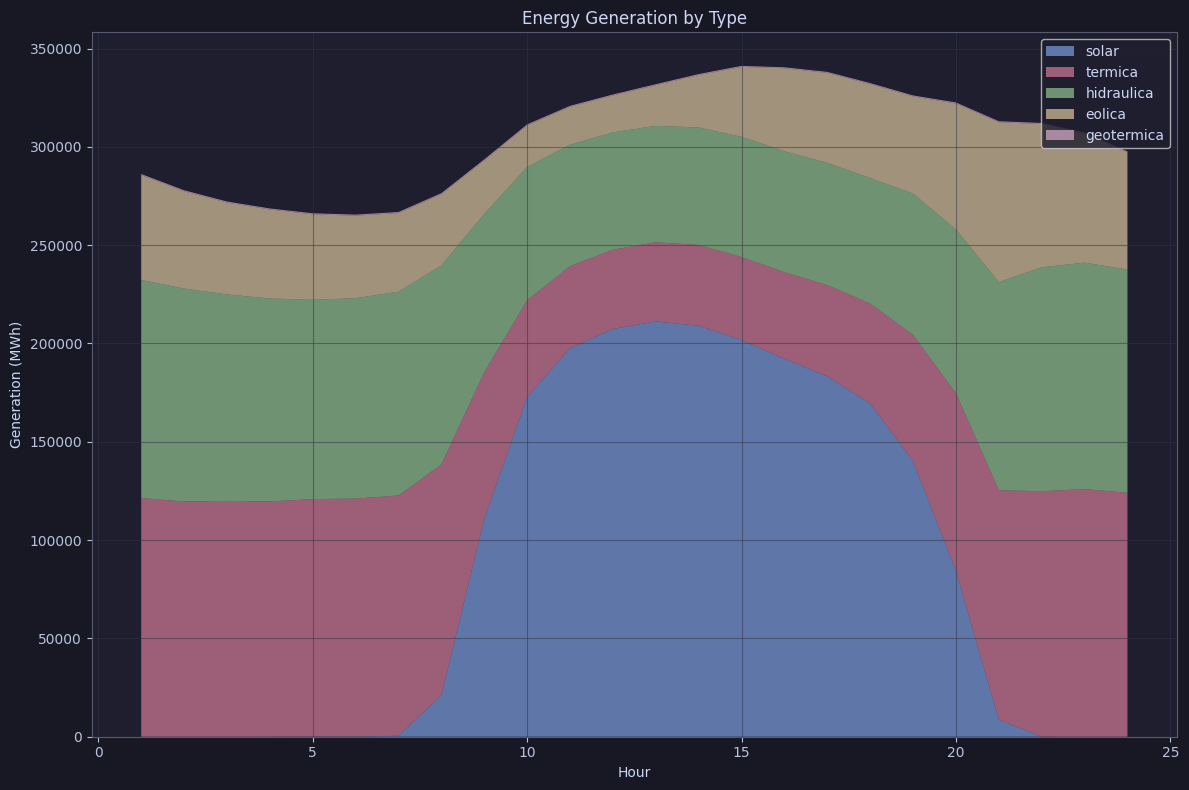

In [ ]:
# Create a stacked area chart
plt.figure(figsize=(12, 8))

# Create the stacked area chart
plt.stackplot(pivot.index, 
              pivot['eolica'], 
              pivot['geotermica'], 
              pivot['hidraulica'], 
              pivot['solar'], 
              pivot['termica'],
              labels=['Eolica', 'Geotermica', 'Hidraulica', 'Solar', 'Termica'],
              alpha=0.8)

# Add labels and title
plt.xlabel("Hour")
plt.ylabel("Generation (MWh)")
plt.title("Energy Generation by Type")
plt.legend(loc="upper right")

# Add grid
plt.grid(True, alpha=0.5)

# Show the plot
plt.tight_layout()
plt.show()

In [118]:
historic.head()

,fecha_opreal,hora_opreal,nemotecnico,nombre,central_nombre,central_infotecnica_id,coordinado,central_tipo,central_tipo_nemotecnico,subtipo,subtipo_nemotecnico,grupo_reporte_nombre,generacion_real_mwh,generacion_real_ernc_mwh
0,2025-01-01,1,ecantera,PMGD PFV Cantera,PMGD PFV CANTERA,1992,GPG GENERACIÓN DISTRIBUIDA SPA,Solar,solar,Solar,solar,PMGD PFV Cantera,0.0,0.0
1,2025-01-01,2,ecantera,PMGD PFV Cantera,PMGD PFV CANTERA,1992,GPG GENERACIÓN DISTRIBUIDA SPA,Solar,solar,Solar,solar,PMGD PFV Cantera,0.0,0.0
2,2025-01-01,3,ecantera,PMGD PFV Cantera,PMGD PFV CANTERA,1992,GPG GENERACIÓN DISTRIBUIDA SPA,Solar,solar,Solar,solar,PMGD PFV Cantera,0.0,0.0
3,2025-01-01,4,ecantera,PMGD PFV Cantera,PMGD PFV CANTERA,1992,GPG GENERACIÓN DISTRIBUIDA SPA,Solar,solar,Solar,solar,PMGD PFV Cantera,0.0,0.0
4,2025-01-01,5,ecantera,PMGD PFV Cantera,PMGD PFV CANTERA,1992,GPG GENERACIÓN DISTRIBUIDA SPA,Solar,solar,Solar,solar,PMGD PFV Cantera,0.0,0.0


In [117]:
historic["subtipo_nemotecnico"].unique()

array(['solar', 'cogeneracion', 'pasada', 'biomasa', 'diesel',
       'gas-natural', 'eolica', 'embalse', 'carbon', 'fuel-oil', 'biogas',
       'geotermica', 'pet-coke'], dtype=object)

In [154]:
pivot.head()

central_tipo_nemotecnico       eolica  geotermica   hidraulica     solar  \
fecha_opreal hora_opreal                                                   
2025-01-01   1            1758.151393       18.50  4079.326029  0.270661   
             2            1700.131981       18.39  3926.373761  0.301668   
             3            1663.942078       18.60  3667.416525  0.345789   
             4            1653.727099       18.69  3530.619425  1.001229   
             5            1624.697985       19.10  3399.627758  2.271713   

central_tipo_nemotecnico      termica  
fecha_opreal hora_opreal               
2025-01-01   1            2765.407100  
             2            3053.674783  
             3            3383.769830  
             4            3425.589537  
             5            3418.604387

In [ ]:
pivot["ernc"] = pivot["solar"] + pivot["eolica"] + pivot["geotermica"]